# CS Project 175 Phase 1

In [2]:
!pip install pandas
!pip install scikit-learn
!pip install matplotlib
!pip install seaborn
!pip install nltk
!pip install langdetect


[notice] A new release of pip available: 22.2.1 -> 22.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.2.1 -> 22.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.2.1 -> 22.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.2.1 -> 22.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.2.1 -> 22.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.2.1 -> 22.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import pandas as pd
import numpy as np

from nltk import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import linear_model 
from sklearn import metrics 
from sklearn import preprocessing

import seaborn

# Analyzing the Data

In [4]:
data = pd.read_csv('./data/data.csv')
del data['Unnamed: 0']
data.head()

,title,genre,lyrics
0,the number of the beast,metal,woe to you o'er earth and sea\nfor the devil s...
1,fear of the dark,metal,i am a man who walks alone\nand when i'm walki...
2,the trooper,metal,you'll take my life but i'll take yours too\ny...
3,hallowed be thy name,metal,i'm waiting in my cold cell when the bell begi...
4,run to the hills,metal,white man came across the sea\nhe brought us p...


Num of rows 295242
biggest class:  118827
smallest class:  12665


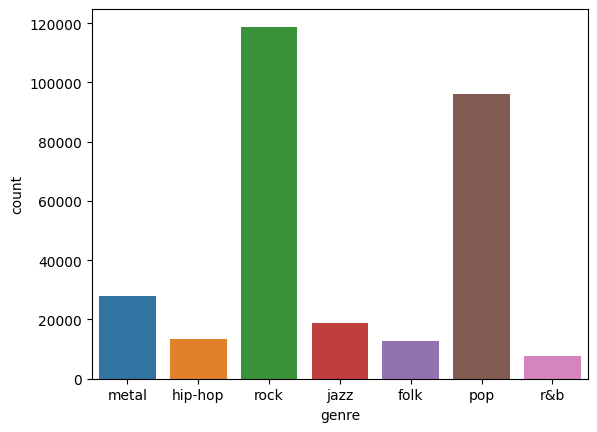

In [5]:
# plot labels
print('Num of rows', len(data))
seaborn.countplot(data, x='genre')
print('biggest class: ', (data['genre'] == max(data['genre'])).sum())
print('smallest class: ', (data['genre'] == min(data['genre'])).sum())


## Building the Pipeline

In [6]:
RANDOM_STATE = 42

def gather_data():
    data = pd.read_csv('./data/data.csv')
    return data['lyrics'], data['genre']

def vectorize_labels(labels, classes=None):
    '''
    Vectorizes the labels.
    Returns as (indexes, labels)
    '''
    if classes is None:
        return pd.factorize(labels)
    return pd.Categorical(labels, categories=classes).codes, classes

def features_bow(data):
    vectorizer = CountVectorizer(stop_words='english', min_df=0.01, ngram_range=(1, 2))
    text = data.to_list()
    X = vectorizer.fit_transform(text)
    return X, vectorizer

def train_model_logistic(X, Y):
    classifier = linear_model.LogisticRegression(penalty='l2', multi_class='multinomial', random_state=RANDOM_STATE, fit_intercept=True)
    classifier.fit(X, Y)
    return classifier

def evaluate_logistic_model(model, X_train, Y_train, X_test, Y_test):
    train_accuracy = model.score(X_train, Y_train)
    print('\nTraining:')
    print(' accuracy:',format( 100*train_accuracy , '.2f') ) 

    # Compute and print accuracy on the test data
    print('\nTesting: ')
    test_accuracy = model.score(X_test, Y_test)
    print(' accuracy:', format( 100*test_accuracy , '.2f') )

    # Compute and print AUC on the test data
    class_probabilities = model.predict_proba(X_test)
    test_auc_score = metrics.roc_auc_score(Y_test, class_probabilities, multi_class='ovo')
    print(' AUC value:', format( 100*test_auc_score , '.2f') )

## Executing the Pipeline

In [7]:
# Phase 1 pipeline
inputs, labels = gather_data()

In [8]:
# convert to features
Y, classes = vectorize_labels(labels)
X, vectorizer = features_bow(inputs)

In [9]:
# split into training and test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=RANDOM_STATE)

In [10]:
# train model
model = train_model_logistic(X_train, Y_train)

c:\Users\luker\Documents\School\2022-2023\fall2022\CS175\proj\venvw\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Evaluating the Model

In [11]:
evaluate_logistic_model(model, X_train, Y_train, X_test, Y_test)


Training:
 accuracy: 57.33

Testing: 
 accuracy: 56.29
 AUC value: 81.26


In [12]:
def most_significant_terms(weights, vectorizer, K):
    pos_indices = np.argpartition(weights, -K)[-K:] # gather the K most positive indices
    pos_indices = pos_indices[np.argsort(-weights[pos_indices])] # sort the indices

    neg_indices = np.argpartition(weights, K)[:K] # gather the K most negative indices
    neg_indices = neg_indices[np.argsort(weights[neg_indices])] # sort the indices

    topK_pos_weights = weights[pos_indices]
    topK_neg_weights = weights[neg_indices]

    # gather the associated terms
    terms = vectorizer.get_feature_names_out()
    topK_pos_terms = terms[pos_indices]
    topK_neg_terms = terms[neg_indices]
        
    # print the positive weights and terms
    print('Top positive weights:')
    for i in range(len(topK_pos_weights)):
        print(format(topK_pos_weights[i], '.3f'), topK_pos_terms[i])
    
    # print the negative weights and terms
    print('Most negative weights:')
    for i in range(len(topK_neg_weights)):
        print(format(topK_neg_weights[i], '.3f'), topK_neg_terms[i])


In [13]:
classes

Index(['metal', 'hip-hop', 'rock', 'jazz', 'folk', 'pop', 'r&b'], dtype='object')

In [14]:
for i in range(len(classes)):
    print('Most Significant Terms for Class: "' + classes[i] + '"')
    most_significant_terms(model.coef_[i], vectorizer, 5)
    print()

Most Significant Terms for Class: "metal"
Top positive weights:
0.349 final
0.342 flesh
0.340 path
0.299 fucking
0.264 souls
Most negative weights:
-0.394 nigga
-0.391 gon
-0.368 niggas
-0.363 lovers
-0.321 darling

Most Significant Terms for Class: "hip-hop"
Top positive weights:
0.409 tryna
0.320 niggas
0.269 gon
0.227 lil
0.226 brothers
Most negative weights:
-0.265 ve got
-0.263 band
-0.189 blues
-0.188 sea
-0.185 someday

Most Significant Terms for Class: "rock"
Top positive weights:
0.213 cos
0.198 guitar
0.133 bleed
0.124 steal
0.116 underneath
Most negative weights:
-0.377 tryna
-0.291 niggas
-0.274 gon
-0.264 mma
-0.241 lil

Most Significant Terms for Class: "jazz"
Top positive weights:
0.368 thrill
0.366 folks
0.352 romance
0.297 kissed
0.276 breeze
Most negative weights:
-0.366 blood
-0.335 pain
-0.287 breathe
-0.285 darkness
-0.285 scared

Most Significant Terms for Class: "folk"
Top positive weights:
0.230 flowers
0.208 sorrow
0.205 yeah yeah
0.196 wife
0.184 guitar
Most n

In [ ]:
predictions = model.predict(X_test)
probabilities = model.predict_proba(X_test)

np.random.seed(RANDOM_STATE)
NUM_EXAMPLES = 10
for _ in range(NUM_EXAMPLES):
    i = np.random.choice(np.where(predictions != Y_test)[0])
    print("Song Title:", data['title'][i])
    print('Predicted:', classes[predictions[i]], 'Actual:', classes[Y_test[i]])
    print('Probability:', probabilities[i][predictions[i]])
    print("Lyrics: ")
    print('"' + data['lyrics'][i][:100] + '..."')
    print()
